## Part 1: Pulse Rate Algorithm

### Project Description

We built an algorithm to predict heart rate, measured in beats per minute (BPM), using wrist-type photoplethysmographic (PPG) and Inertial Measurement Unit (IMU) signals that were recorded during various activities. We also simultaneously record each participant's ECG signals from their chest using wet ECG sensors. The recorded ECG signals were then converted into heart rates, calculated in beats per minute (BPM) and used as a reference to measure the algorithm's performance.

This problem is challenging especially during intensive exercises since the signals are contaminated by extremely strong motion artifacts (MA) caused by subjects' hand movements.

The code is available as a library in the script located in the same directory with this notebook whose name is `troika.py`. The algorithm churns out two values: the predicted heart rate (BPM) and its confidence rate of the prediction.

In the "Code" section below, a code cell can be run to execute the algorithm with a given dataset and measure its performance.

### Data Description

We will be using the **Troika**[1] dataset to build our algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. [Link](https://arxiv.org/pdf/1409.5181.pdf)

Some remarks on the number of channels of the signals:

- ECG signals have one channel.
- PPG signals have two channels. In this project, we take the mean from both channels.
- Accelerometers have three channels, each corresponding to a space axis (x, y, and z). We use the L2-norm of the magnitude of these three channels i.e. the distance measured by this formula: `sqrt(x**2 + y**2 + z**2)`.

### Algorithm Description

The algorithm uses linear regression to find coefficients that best fit the training heart rate data. This very simple model was chosen as opposed to more complex models after considering the result of the analysis, that is, even a simple algorithm that selects the frequency of the highest spectrum magnitude from the PPG signals, without taking into account MA effects, does extremely well especially on the test data (more on this in the next section).

Here are the steps to run the algorithm:

1. Run the script `prepare_regressor.py`. This script will produce a regression model in the form of a [Pickle](https://docs.python.org/3/library/pickle.html) object that we can load and use to perform predictions on new data.
2. Run the code cell below to check the performance of the algorithm on the training data.
3. Testing data are available in the directory `datasets/troika/testing_data` if you'd like to see the performance of the model on new data.

PPG signals can be used for measuring heart rate due to the following aspects of the physiology of human blood vessels: 1) capillaries in the wrist fill with blood when the ventricles contract; and 2) when the blood returns to the heart, there are fewer red blood cells in the wrist. During state 1, the (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capillaries and the photodetector will see the drop in reflected light. During state 2, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

As mentioned above, the algorithm churns out two values: the predicted heart rate (BPM) and its confidence rate of the prediction. The higher the confidence rate is, (theoretically,) the more likely is the prediction to be correct.

A caveat: The confidence rate is only calculated based on the magnitude of a small area that contains the estimated spectral frequency relative to the sum magnitude of the entire spectrum.

The condition that may cause the algorithm to fail is when the PPG picks a higher frequency signal that is not from the heart rate. This is possible due to MA contaminations from hand movements. To deal with this problem, we take into consideration the accelerations in the algorithm.

### Algorithm Performance

The performance was calculated by calculating the mean absolute error between the HR estimation and the reference HR from the ECG sensors at 90% availability. Put another way, 90% of the best estimates according to the algorithm's confidence scores. For this project, the requirement is to have lower than 15 BPM of this measurement error score on the test set.

In building the linear regression model, we use Leave One Group Out (LOGO) cross-validation to exclude data from one of the subjects out of the training data. This is to ensure that the model we built would generalize to a new person better.

The error of the model in the testing data is  7.01 BPM. While this is low enough to pass the specification, this is still inferior to the simple algorithm that just selects the frequency that corresponds to the highest magnitude from the mean of both PPG signals. This simple algorithm got only 0.60 BPM in the test data. However, the score is very slightly better for the model-based algorithm in the training data (13.254 BPM for the model-based vs 13.365 BPM for the simple algo).

As we only have 12 subjects, the algorithm may not be as generalizable as we'd like when used for a large population. To improve its generalizability, more test subjects are needed.


### References

- Signal Processing basics: https://allsignalprocessing.com/introductory-content/
- Code for BandpassFilter: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
- Code for SSA: https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
- Using `scipy.optimize`: https://stackoverflow.com/questions/51883058/l1-norm-instead-of-l2-norm-for-cost-function-in-regression-model/51896790

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.stats
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import sys
sys.path.append("../lib")
import troika
import mpld3
import pickle

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = troika.LoadTroikaDataset("./datasets/troika/training_data")
    errs, confs = [], []
    pbar = tqdm(list(zip(data_fls, ref_fls)))
    for data_fl, ref_fl in pbar:
        pbar.set_description("{} and {}".format(data_fl.split('/')[-1], ref_fl.split('/')[-1]))
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
#         break
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

log = None
FS = 125
WINDOW_LEN_S = 8
WINDOW_SHIFT_S = 2
PAST_WINDOW = 3
PASS_BAND = (40/60.0, 240/60.0)
MULTIPLIER = 4

def RunPulseRateAlgorithm(data_fl, ref_fl, log_vars=True):
    """
    Run Pulse Rate Algorithm
    
    Loads data and model, then calculate errors and confidence rates from the data.
    
    Args:
        data_fl: (string) Path to data file (MATLAB data)
        ref_fl: (string) Path to reference data file (MATLAB data)
        log_vars: (bool) If True, log some variables in the `log` object for further analysis
        
    Returns:
        (np.array) Error scores
        (np.array) Confidence rates
    """
    global log

    # Frequency of the signals sampled in Hertz.
    # For example, 125 means there are 125 samples every second.
    fs = FS # Hertz
    
    # Each reference pulse rate is calculated from this many seconds.
    window_len_s = WINDOW_LEN_S
    
    # Time difference (in seconds) between one time window and the next.
    window_shift_s = WINDOW_SHIFT_S
    
    # Zero-padding the frequencies by x times this.
    multiplier = MULTIPLIER
    
    # Bandpass filter limits
    pass_band = PASS_BAND

    
    predictor = troika.TroikaPredictor(
        '../reg.pkl',
        fs=fs,
        pass_band=pass_band,
        multiplier=multiplier,
        log_vars=True)
    
    # Load data using scipy. "scipy.io.loadmat(f)"
    sigs = scipy.io.loadmat(data_fl)['sig']
    refs = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    if log_vars:
        predictor.log.prepare(sigs=sigs, refs=refs, fl=data_fl)
    
    errors = []
    confidence = []
    estimations = []
    
    largest_error = None
    
    start_idxs, end_idxs = troika.get_idxs(sigs.shape[1], len(refs),
                                           fs=fs,
                                           window_len_s=window_len_s,
                                           window_shift_s=window_shift_s)
    
    for i, start_idx in enumerate(start_idxs):
        end_idx = end_idxs[i]
        
        # ECG-related
        ecg = sigs[0, start_idx:end_idx]
        ref = refs[i]
        
        # Start working on the signals below
        ppg1 = sigs[1, start_idx:end_idx]
        ppg2 = sigs[2, start_idx:end_idx]
        accx = sigs[3, start_idx:end_idx]
        accy = sigs[4, start_idx:end_idx]
        accz = sigs[5, start_idx:end_idx]
        
        est, conf = predictor.predict(ppg1, ppg2, accx, accy, accz)

        if log_vars:
            predictor.log.prepare(i=i, ref=ref, ecg=ecg, est=est, conf=conf)

        error = np.abs(est - ref)
        
        if log_vars and (largest_error is None or error > largest_error):
#         if log_vars and (i == 0 and 'DATA_12_TYPE02' in data_fl):
            predictor.log.commit()
            log = predictor.log
            
            largest_error = error
        
        errors.append(error)
        confidence.append(conf)
        estimations.append(est)
    
    return np.array(errors), np.array(confidence)

Evaluate()

13.254323301072764

## Analysis

### Ploting Functions

In [2]:
from matplotlib.lines import Line2D

def plot_freq(ax_freq, freqs, fft, fs, target_hz, est=None, title='None', freq_xlim=(0.4, 5)):
    """
    Plot a frequency-domain plot
    
    Args:
        ax_freq: (matplotlib.axes.Axes) Axes object to draw the plot onto
        freqs: (np.array) List of frequencies
        fft: (np.array) List of magnitudes
        fs: (int) Sampling frequency in Hz
        target_hz: (float) Target's frequency in Hz
        est: (float) Estimated frequency in Hz
        title: (string) Title of plot
        freq_xlim: ((float, float)) x-axis limits
    """
    ax_freq.plot(freqs, fft, 'bo-')
    ax_freq.plot([target_hz, target_hz], [0, max(fft)], 'r')
    # Create legends manually
    custom_lines = [Line2D([0], [0], color='r', lw=1)]
    
    if est is not None:
        ax_freq.plot([est, est], [0, max(fft)], 'black')
        custom_lines.append(Line2D([0], [0], color='black', lw=1))
        ax_freq.legend(custom_lines, ['Reference HR', 'Estimation'])
    else:
        ax_freq.legend(custom_lines, ['Reference HR'])
        
    ax_freq.set_title(title)
    ax_freq.set_xlabel('Frequency (Hz)')
    ax_freq.set_ylabel('Magnitude')
    ax_freq.set_xlim(freq_xlim)
    

    
def plot_time_freq(ax_time, ax_freq, data, fs, target_hz,
                   est=None, title='Plot', freq_xlim=(0.4, 5), pass_band=None, multiplier=2):
    """
    Plot both time and frequency-domain plots
    
    Args:
        ax_time: (matplotlib.axes.Axes) Axes object to draw the time plot onto
        ax_freq: (matplotlib.axes.Axes) Axes object to draw the frequency domain plot onto
        data: (np.array) Data to be drawn
        fs: (int) Sampling frequency in Hz
        target_hz: (float) Target's frequency in Hz
        est: (float) Estimated frequency in Hz
        title: (string) Title of plot
        freq_xlim: ((float, float)) x-axis limits
        pass_band: ((float, float)) min and max pass bands tuple
        multiplier: (int) The number of frequencies should be multiplied by this
    """
    ax_time.plot(data)
    ax_time.set_title(title)
    ax_time.set_ylabel('Magnitude')

    n = len(data) * multiplier
    freqs = np.fft.rfftfreq(n, 1/fs)
    fft = np.abs(np.fft.rfft(data, n))
    
    if pass_band is not None:
        fft[freqs <= pass_band[0]] = 0.0
        fft[freqs >= pass_band[1]] = 0.0
    
    plot_freq(ax_freq, freqs, fft, fs, target_hz,
              est=est, title="{} - Frequency Domain".format(title), freq_xlim=freq_xlim)

### Spectograms

In [3]:
mpld3.disable_notebook()
def plot_spec(data_fl, ref_fl, fs=125, window_len_s=8, pass_band=(0.4, 5.0)):
    """
    Plot a spectogram
    
    Args:
        data_fl: (string) Filename of the file that contains the data
        ref_fl: (string) Filename of the file that contains the references
        fs: (int) Sampling frequency in Hz
        window_len_s: (int) Window length in seconds
        pass_band: ((float, float)) min and max pass bands tuple

    """
    # Load data using scipy. "scipy.io.loadmat(f)"
    sigs = scipy.io.loadmat(data_fl)['sig']
    refs = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    ppg1 = sigs[1, :]
    ppg2 = sigs[2, :]
    ppg = np.mean(np.vstack([ppg1, ppg2]), axis=0)
    
    spec, freqs, t, cax = plt.specgram(ppg, Fs=fs, NFFT=fs * window_len_s)
    plt.ylim(pass_band[0],pass_band[1])
    plt.title("PPG mean for {}".format(data_fl.split('/')[-1]))
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(cax)

In [4]:
data_fls, ref_fls = troika.LoadTroikaDataset("./datasets/troika/training_data")

# Frequency of the signals sampled in Hertz.
# For example, 125 means there are 125 samples every second.
fs = FS # Hertz

# Each reference pulse rate is calculated from this many seconds.
window_len_s = WINDOW_LEN_S # seconds

# Time difference (in seconds) between one time window and the next.
window_shift_s = WINDOW_SHIFT_S # seconds

pass_band = PASS_BAND

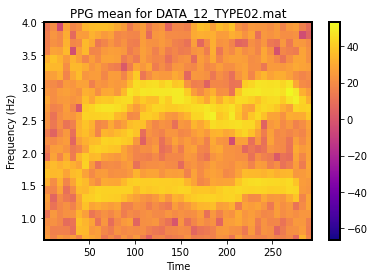

In [5]:
plot_spec(data_fls[11], ref_fls[11], fs=fs, window_len_s=window_len_s, pass_band=pass_band)

## Plotting the worst fit

File: ./datasets/troika/training_data/DATA_12_TYPE02.mat
i: 81
Ground Truth: 158.7302 BPM or 2.645503333333333 Hz
estimation: 104.35384060084453 BPM or 1.7392306766807422 Hz
diff: 0.9062726566525909
Confidence: 0.030787138140634673


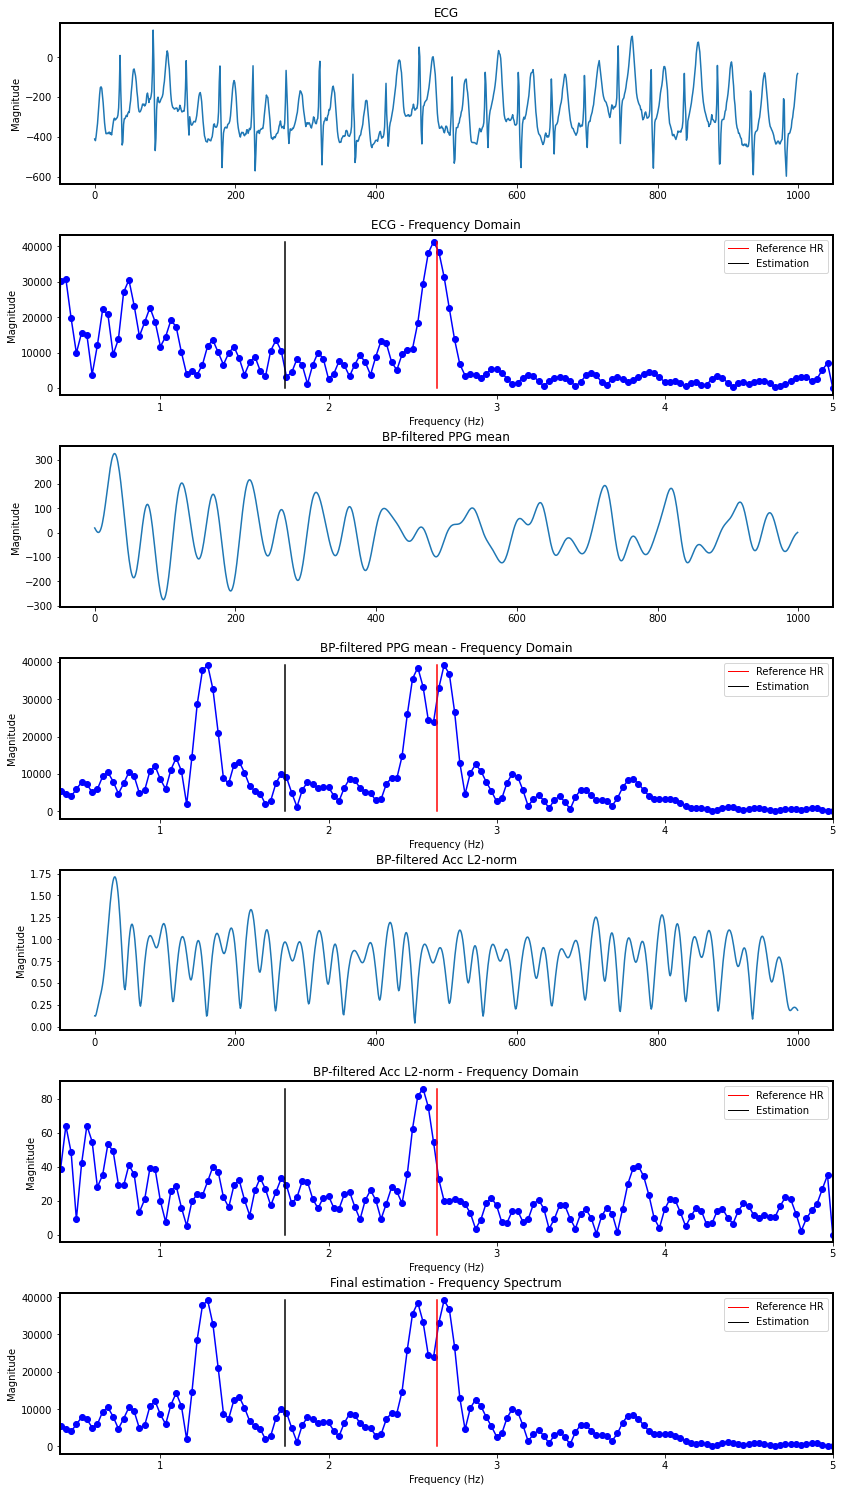

In [6]:
mpld3.enable_notebook()
fs = 125

print("File: {}\ni: {}".format(log.fl, log.i))

ref_hz = log.ref / 60.0
print("Ground Truth: {} BPM or {} Hz".format(log.ref, ref_hz))
pass_band = (0.4, 5.0)
ecg = log.ecg
ppg1 = log.ppg1
ppg2 = log.ppg2
ppg1_bp = log.ppg1_bp
ppg2_bp = log.ppg2_bp
ppg = log.ppg
ppg_bp = log.ppg_bp
accx = log.accx
accy = log.accy
accz = log.accz
accx_bp = log.accx_bp
accy_bp = log.accy_bp
accz_bp = log.accz_bp
est = log.est
conf = log.conf

numplots = 7
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(12,numplots * 3))
fig.tight_layout(pad=3.0)

# Get PPG power spectrums
n = len(ppg_bp) * MULTIPLIER
freqs = np.fft.rfftfreq(n, 1/fs)
fft = np.abs(np.fft.rfft(ppg_bp, n))
fft[freqs <= pass_band[0]] = 0.0
fft[freqs >= pass_band[1]] = 0.0


# Get L2-norms of accelerations
acc_l2 = np.sqrt(accx_bp ** 2 + accy_bp ** 2 + accz_bp ** 2)

# Get acceleration power spectrums
acc_freqs = np.fft.rfftfreq(n, 1/fs)
acc_fft = np.abs(np.fft.rfft(acc_l2, n))
acc_fft[acc_freqs <= pass_band[0]] = 0.0
acc_fft[acc_freqs >= pass_band[1]] = 0.0

est_fs = est / 60.0

plot_time_freq(ax[0], ax[1], ecg, fs, ref_hz, est=est_fs, title="ECG", pass_band=pass_band, multiplier=MULTIPLIER)
plot_time_freq(ax[2], ax[3], ppg_bp, fs, ref_hz, est=est_fs, title="BP-filtered PPG mean", pass_band=pass_band, multiplier=MULTIPLIER)
plot_time_freq(ax[4], ax[5], acc_l2, fs, ref_hz, est=est_fs, title="BP-filtered Acc L2-norm", pass_band=pass_band, multiplier=MULTIPLIER)
plot_freq(ax[6], freqs, fft, fs, ref_hz, est=est_fs, title="Final estimation - Frequency Spectrum")

print("estimation: {} BPM or {} Hz".format(est, est_fs))
print("diff: {}".format(np.abs(est_fs - ref_hz)))

fs_window = 5 / 60.0
est_fs_window = (freqs >= est_fs - fs_window) & (freqs <= est_fs + fs_window)
conf = np.sum(fft[est_fs_window]) / np.nansum(fft)
print("Confidence: {}".format(conf))


Looks like the model was confused due to the existence of multiple PPG spectrum peaks. We can perhaps remove all spectrums whose magnitudes are below a certain threshold to increase the sparsity of the frequencies. With fewer options to pick from, hopefully the model would perform better.

## Sparse Signal Reconstruction with FOCUSS

We followed the instruction from Zhang's paper to perform FOCUSS SSR to separate the noise from the signal. However, the result may not mean much without the entire framework implemented.

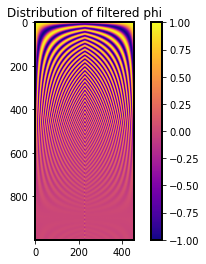

In [7]:
mpld3.disable_notebook()

def SSR(y, fs=125, M=1000, N=64**2, pass_band=(0.4, 5.0), noise=0.1, g_p=0.8, max_iter=5, random_seed=13):
    """ Get SSR spectrum from a given data
    """

    def get_prune_limits(phi, N, fs, pass_band):
        low_band = pass_band[0]
        high_band = pass_band[1]
        delta_f1 = low_band / float(fs) * N - 1
        delta_f2 = 2 / float(fs) * N

        f1_l1 = low_band / float(fs) * N + 1 - delta_f1
        f1_l2 = high_band / float(fs) * N + 1 + delta_f2
        f2_l1 = N - high_band / fs * N + 1 - delta_f2
        f2_l2 = N - low_band / fs * N + 1 + delta_f1
        return (int(f1_l1), int(f1_l2), int(f2_l1), int(f2_l2))


    mtx_M = np.linspace(0, M-1, M).reshape(M, 1)
    mtx_N = np.linspace(0, N-1, N).reshape(1, N)
    mtx_MN = mtx_M.dot(mtx_N)

    phi = np.exp(1j * 2*(np.pi/N) * mtx_MN)
    f1_l1, f1_l2, f2_l1, f2_l2 = get_prune_limits(phi, N, fs, pass_band)

    phi = phi[:, np.r_[f1_l1:f1_l2, f2_l1:f2_l2]]
    phi = np.real(phi)

    # Plot
    plt.imshow(np.real(phi))
    plt.colorbar();
    plt.title("Distribution of filtered phi")

    def g(x):
        return np.linalg.norm(x, ord=g_p)

    def objective(x, y, phi, noise):
        return np.linalg.norm(y-(phi.dot(x)), ord=2)**2 + noise * g(x)

    np.random.seed(random_seed)
    x0 = np.random.randn(N)
    x0 = x0[np.r_[f1_l1:f1_l2, f2_l1:f2_l2]]

    output = scipy.optimize.minimize(objective, x0,
                                     options={'maxiter': max_iter},
                                     args=(y, phi, noise))
    return output

output = SSR(acc_l2,
             fs=125,
             M=8 * fs,
             N=64**2,
             pass_band=pass_band)

This is how a correct `x_hat` value distribution looks like:

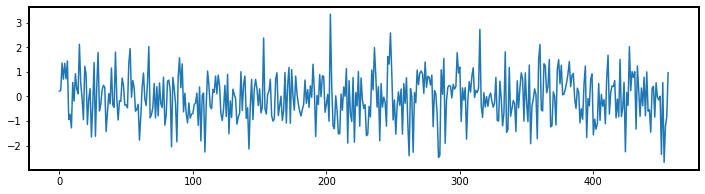

In [8]:
mpld3.enable_notebook()
plt.figure(figsize=(12, 3))
plt.plot(output.x);

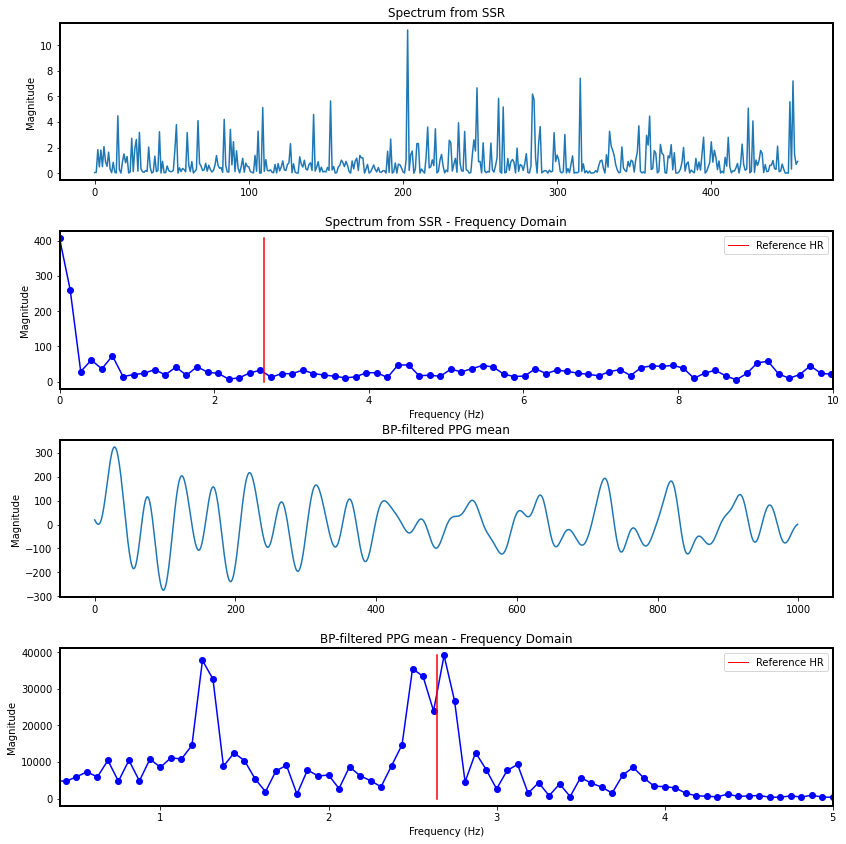

In [9]:
mpld3.enable_notebook()

# Get spectrum
s = output.x**2


numplots = 4
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(12,numplots * 3))
fig.tight_layout(pad=3.0)

plot_time_freq(ax[0], ax[1], s, fs, ref_hz, title='Spectrum from SSR', freq_xlim=(0, 10))
plot_time_freq(ax[2], ax[3], ppg_bp, fs, ref_hz, title="BP-filtered PPG mean")